정기 구독률 계산

In [80]:
import pandas as pd

df_member = pd.read_csv("Member_Data.csv", encoding="cp949")
df_product = pd.read_csv("Product_Data.csv", encoding="utf-8")
df_sales = pd.read_csv("Sales_Data05.csv", encoding="cp949")

# 전체 회원 수 계산
total_members = len(df_member)

# '구독여부'가 True인 고객 수 계산
subscribed_members = member_df[member_df['구독여부'] == True].shape[0]

# 비율 계산
subscription_ratio = (subscribed_members / total_members) * 100

# 결과 출력
print(f"구독 여부가 TRUE인 고객 비율: {subscription_ratio:.2f}%")

구독 여부가 TRUE인 고객 비율: 13.98%


유령고객 계산

In [81]:
import pandas as pd

# 데이터 타입 변환
df_sales['주문일시'] = pd.to_datetime(df_sales['주문일시'], errors='coerce')
df_member['회원번호'] = df_member['회원번호'].astype(str)
df_sales['회원번호'] = df_sales['회원번호'].astype(str)

# n일 동안 주문이 없으면 유령 고객
n = 30
last_order_dt = df_sales['주문일시'].max()

# 회원별 최근 주문일을 Pivot Table을 사용하여 계산
df_last_order = pd.pivot_table(df_sales, index="회원번호", values="주문일시", aggfunc="max").reset_index()

# 탈퇴하지 않은 회원 데이터와 최근 주문 데이터 결합
df_active = df_member[df_member['회원상태'] != '탈퇴'].merge(df_last_order, on='회원번호', how='left')

# 주문 기간 계산 및 유령 고객 비율 계산
ghost_rate = ((last_order_dt - df_active['주문일시'].fillna(last_order_dt)).dt.days >= n).mean() * 100

# 결과 출력
print(f"최근 {n}일간 주문이 없는 유령 고객 비율: {ghost_rate:.2f}%")

최근 30일간 주문이 없는 유령 고객 비율: 50.17%


RFM분석

In [75]:
import pandas as pd

# 날짜 변환
df_sales['주문일시'] = pd.to_datetime(df_sales['주문일시'], errors='coerce')
latest_date = df_sales['주문일시'].max()  # 데이터 내 최신 주문일

# RFM분석
rfm = pd.pivot_table(df_sales, index="회원번호",values=["주문일시", "구매금액"],
    aggfunc={"주문일시": [lambda x: (latest_date - x.max()).days, "count"], "구매금액": "sum"}).reset_index()

# 컬럼 이름 변경
rfm.columns = ["회원번호", "Recency", "Frequency", "Monetary"]

# RFM 점수 (5단계 )
rfm["R_Score"] = pd.qcut(rfm["Recency"], 5, labels=[5, 4, 3, 2, 1])
rfm["F_Score"] = pd.qcut(rfm["Frequency"], 5, labels=[1, 2, 3, 4, 5])
rfm["M_Score"] = pd.qcut(rfm["Monetary"], 5, labels=[1, 2, 3, 4, 5])

# 최종 RFM 점수 계산
rfm["RFM_Score"] = rfm[["R_Score", "F_Score", "M_Score"]].astype(int).sum(axis=1)

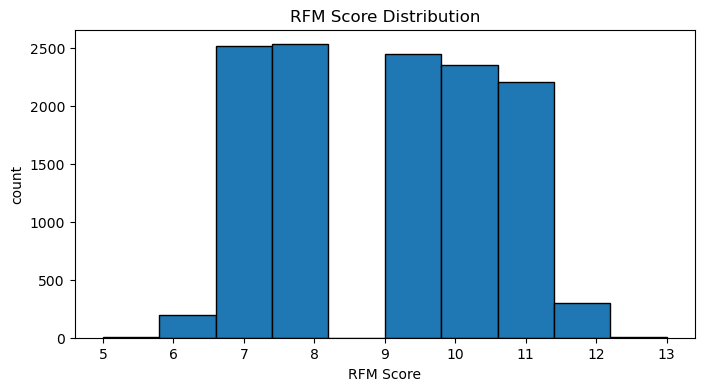

In [87]:
import matplotlib.pyplot as plt

# RFM Score 분포 히스토그램
plt.figure(figsize=(8, 4))
plt.hist(rfm["RFM_Score"], edgecolor="black")
plt.title("RFM Score Distribution")
plt.xlabel("RFM Score")
plt.ylabel("count")
plt.show()